## AIDI 1002 - LAB 3/4
## Machine Learning: Support Vector Machines

Michael Molnar (1008068623)

### Problem Description:

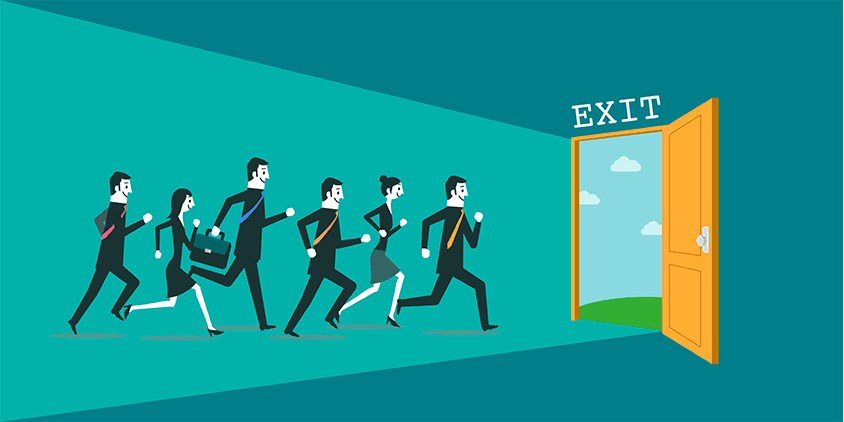

In [109]:
from IPython.display import Image
Image(filename = 'churn_image.png')

(Image Source: https://www.pointillist.com/blog/reduce-churn-customer-journey-analytics/)

Customer churn, or customer attrition, is a measure of the percentage of your customers that stop using your company's products or services.  Besides the obvious loss of revenue from these customers, customer churn has other negative results: 
- marketing and customer acquisition costs might not yet have been covered, thus resulting in a loss
- it is more expensive to acquire a new customer than it is to keep a current paying customer 

Understanding customer churn helps in understanding the health and long term success of your company.  


It is for these reasons that being able to predict and identify characteristics of customers who are at high risk of churning is vitally important.  Before the customer takes their business elsewhere, steps can be taken to address the situation and potentially retain them.  Studying the attributes of customers can give a sense of the the factors that can be used to predict these events before they happen.

This lab will study the Customer Churn in Telecoms dataset.  The data consists of many columns of customer information and the final label - whether they churned or not.  The goal will be to study Support Vector Machines to determine the success of a classification model in determining this label given this data.

### Loading the Necessary Packages:

In [110]:
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

### Loading and Examining the Data:

#### Dataset Source: https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

In [111]:
# Load the CSV file into a Pandas DataFrame
df_churn = pd.read_csv('churn.csv')

In [112]:
df_churn.shape

(3333, 21)

In [113]:
df_churn.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

#### Observations:
- We have a couple categorical features - state, area code, international plan, voicemail plan.
- These will be encoded with labels prior to modelling. 
- Phone Number will be unique to each customer and will not provide any information, and so it will be dropped.
- The rest of the features are numeric - some discrete and some continuous.
- These will be examined for outliers and then scaled before modelling.  

In [114]:
# Check for missing values 
df_churn.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [115]:
# Check for any duplicate rows
duplicate_rows_df = df_churn[df_churn.duplicated()]
print("Duplicated Rows:")
print(duplicate_rows_df)

Duplicated Rows:
Empty DataFrame
Columns: [state, account length, area code, phone number, international plan, voice mail plan, number vmail messages, total day minutes, total day calls, total day charge, total eve minutes, total eve calls, total eve charge, total night minutes, total night calls, total night charge, total intl minutes, total intl calls, total intl charge, customer service calls, churn]
Index: []

[0 rows x 21 columns]


There are no missing value and each row is unique.

In [116]:
# Get statistical analysis
df_churn.describe()

account length    area code  number vmail messages  total day minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total day calls  total day charge  total eve minutes  total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       total eve charge  total night minutes  total night calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       total night charge  total intl minutes  total intl calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       total intl charge  customer service calls  
count        3333.000000             3333.000000  
mean            2.764581                1.562856  
std             0.753773                1.315491  
min             0.000000                0.000000  
25%             2.300000                1.000000  
50%             2.780000                1.000000  
75%             3.270000                2.000000  
max             5.400000                9.000000

I will examine for outliers later, but just noting the means and the maximums and minimums there doesn't appear to be anything that is too far out of line.  As previously mentioned, the data will be standardized due to the very wide range in scale across the columns.

#### Prepare a Sweet Viz Report

In [117]:
churn_report = sv.analyze(df_churn)

:FEATURES DONE:                    |█████████████████████| [100%]   00:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!


In [118]:
churn_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


#### Observations:
- Most of the features are very nicely normally distributed
- The number of voice mail messages has most values around 0 but then some between 10 and 50.  This will be examined when individual features are looked at in the coming sections
- More people have one customer service call than any other value. 
- The distribution of the targets - churn or not churn - is highly imbalanced

### Examining the Target Variable:  Churn

In [119]:
# Get the counts
df_churn['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

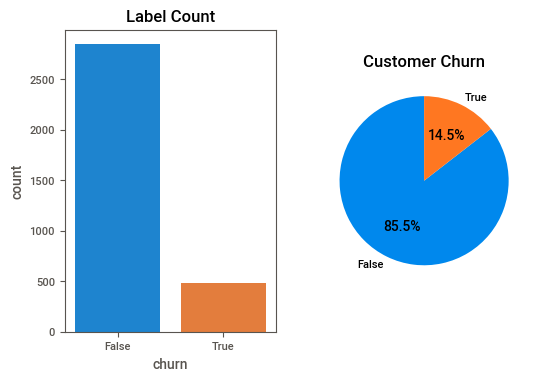

In [120]:
# Plot as a bar graph and a pie graph
fig = plt.figure()

ax = fig.add_subplot(121)
ax = sns.countplot(x = 'churn', data = df_churn)
ax.set_title('Label Count')

ax2 = fig.add_subplot(122)
labels = ['False', 'True']
sizes = [2850/3333, 483/3333]

ax2 = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Customer Churn")

plt.show()

There is an imbalance in the distribution of the labels.  This will be addressed in two ways - using stratified k-fold cross-validation to maintain the distribution of labels in the training and testing data, and then by using the balanced accuracy score, and confusion matrix, to measure the model's accuracy in place of accuracy score. 

### Examining the Categorical Features

#### State

In [121]:
df_churn['state'].nunique()

51

The data consists of residents of all 50 US states as well as the District of Columbia.

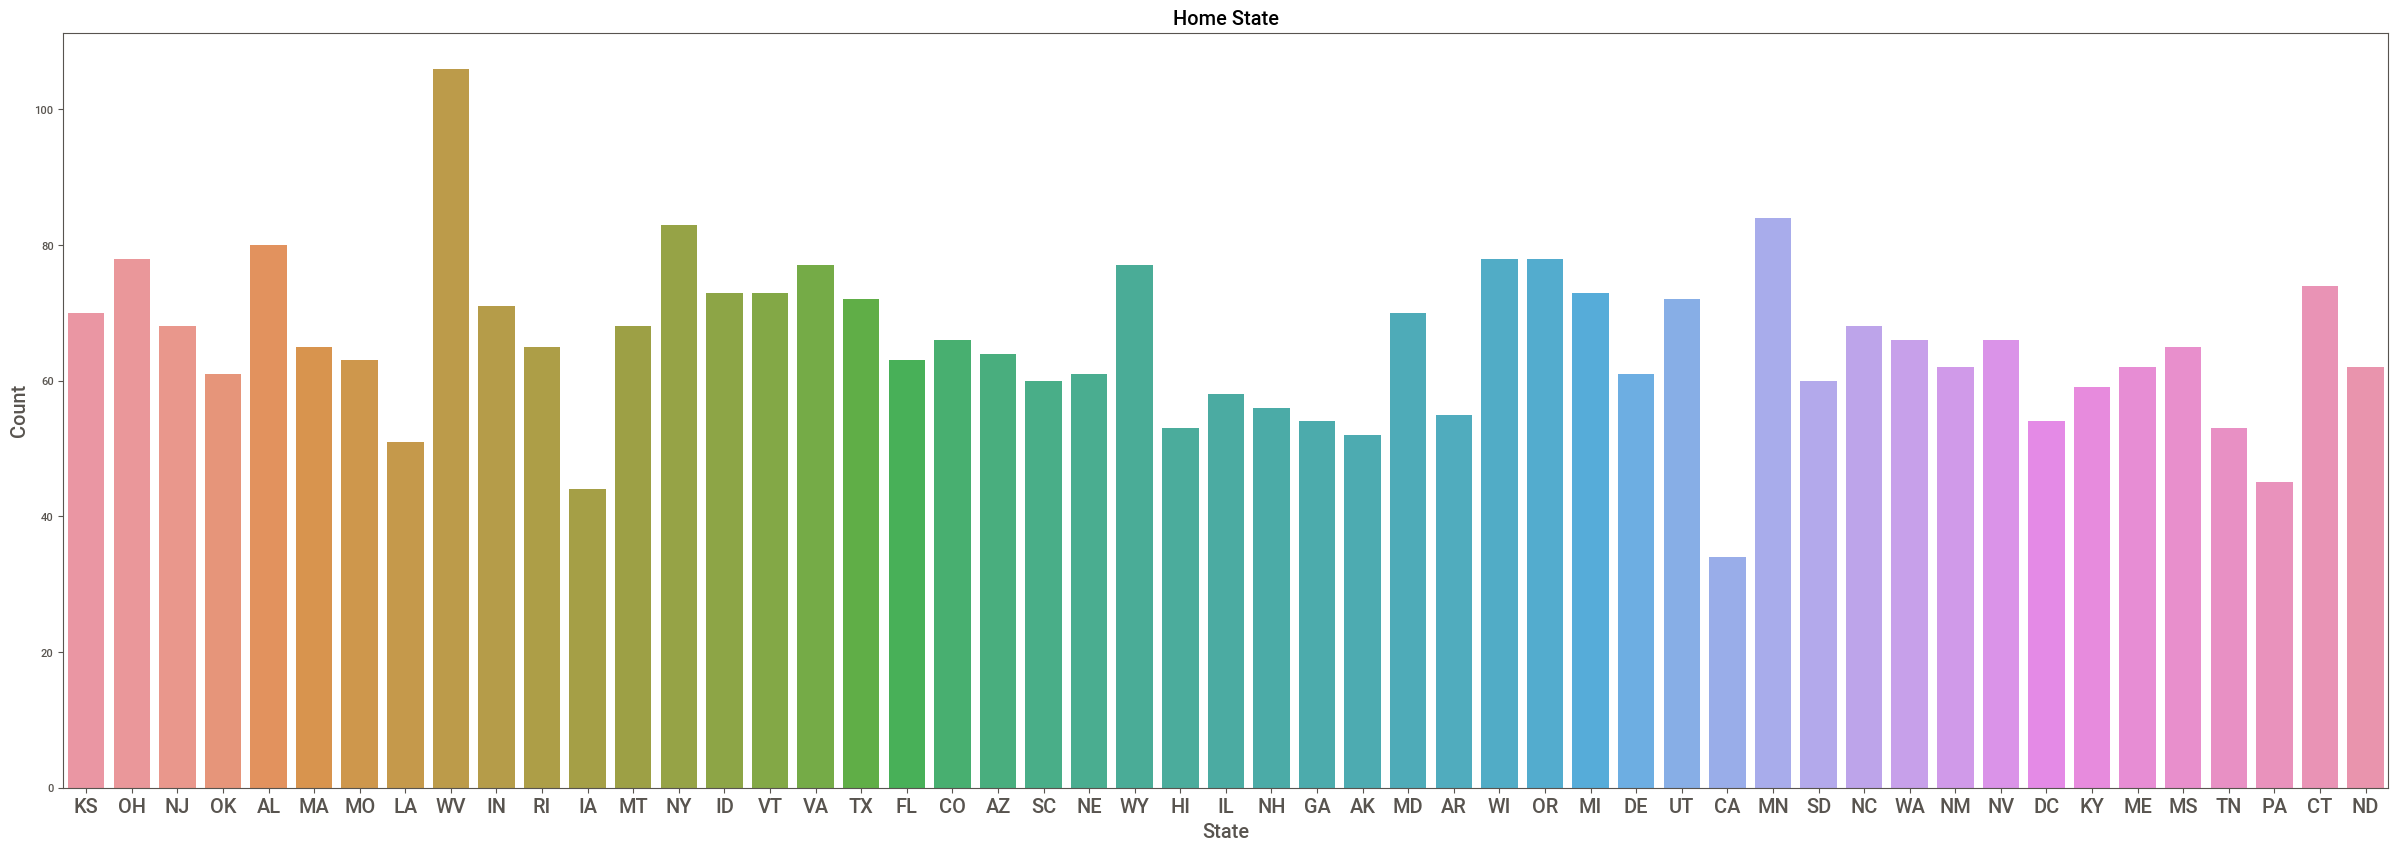

In [122]:
# Plot the distribution and then the distributions according to the class labels
f= plt.figure(figsize=(30,10))

ax=f.add_subplot(111)
ax=sns.countplot(x='state', data=df_churn)
ax.set_xlabel('State', fontsize='x-large')
ax.set_ylabel('Count', fontsize='x-large')
ax.set_title('Home State', fontsize='x-large')
ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

plt.show()

The data but state is reasonably uniform, though the highest number of people represented in the data come from West Virginia and the lowest are from California.

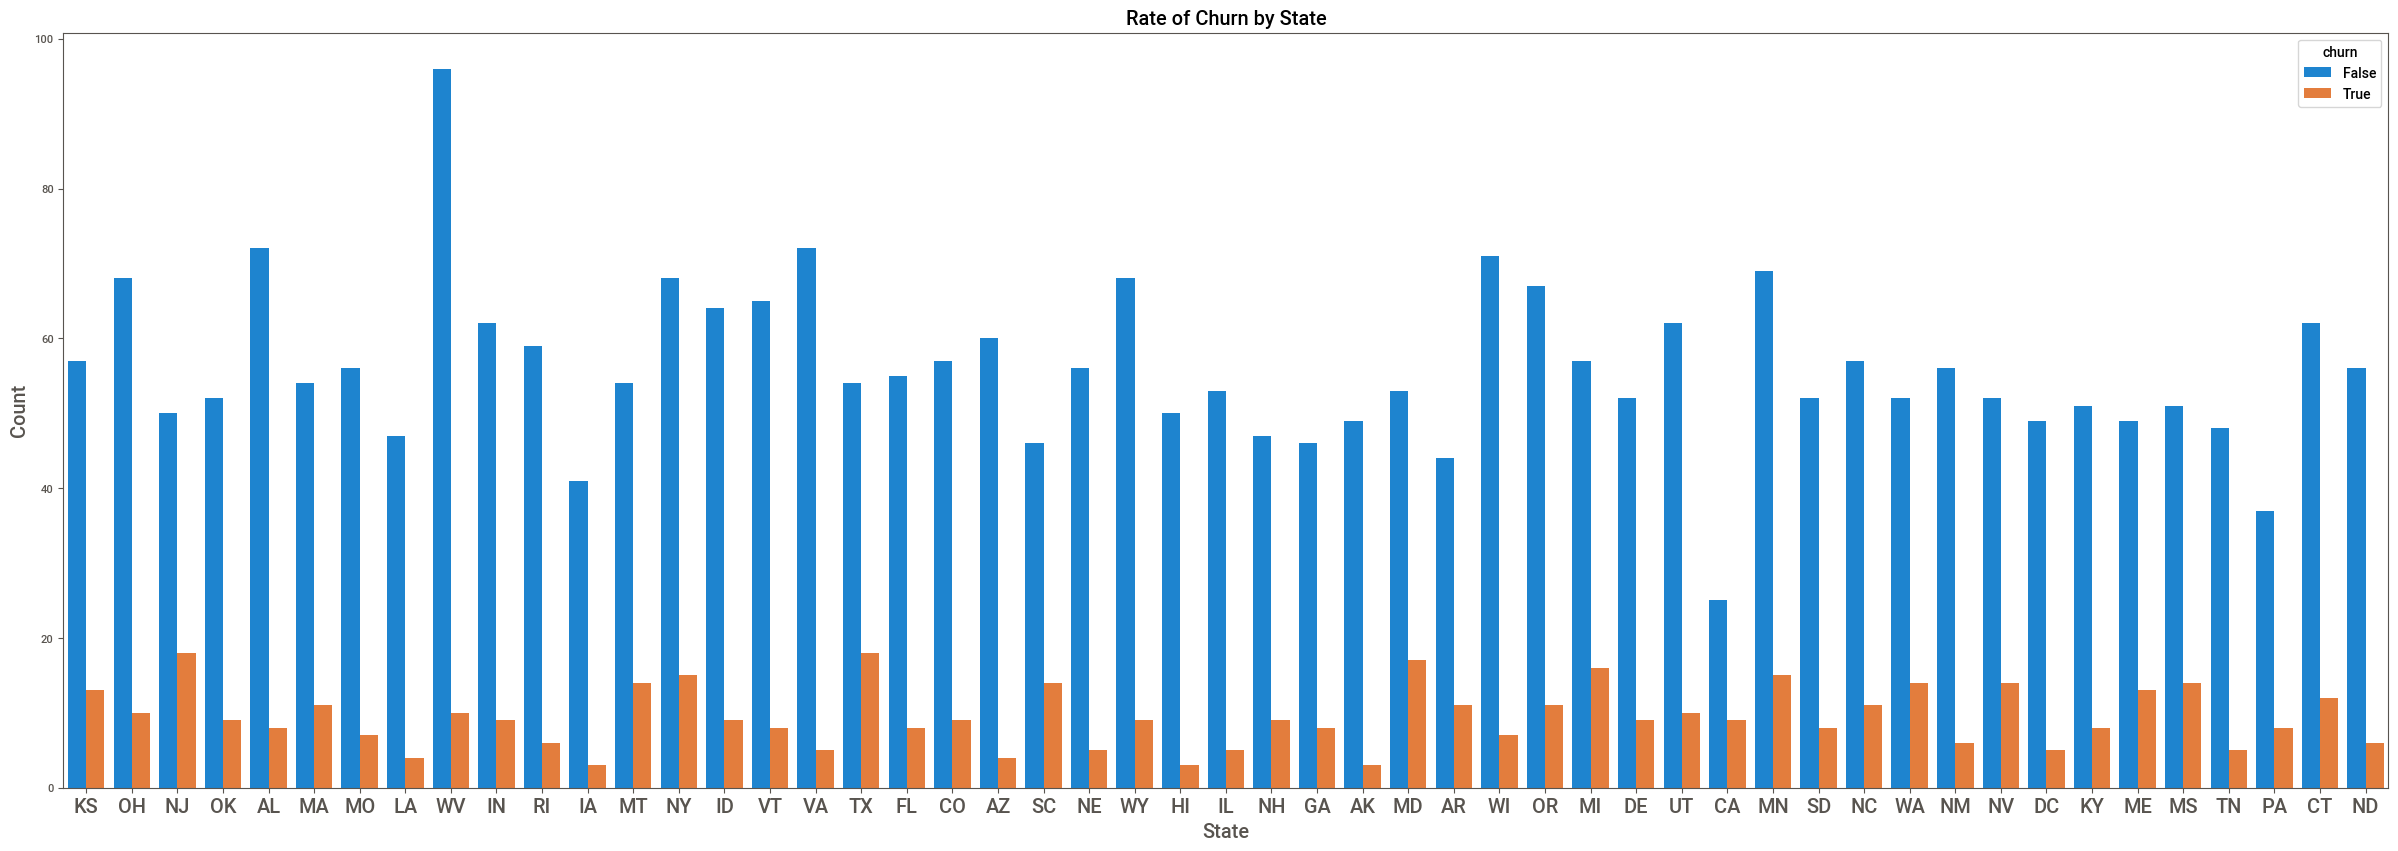

In [123]:
# Plotting churn by state
f= plt.figure(figsize=(30,10))
ax2=f.add_subplot(111)
ax2 = sns.countplot(x = 'state', hue = 'churn', data = df_churn)
ax2.set_xlabel('State', fontsize='x-large')
ax2.set_ylabel('Count', fontsize='x-large')
ax2.set_title('Rate of Churn by State', fontsize='x-large')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

plt.show()

There are a couple interesting things here - customers are very unlikely to churn in states like Virginia and West Virginia, but more likely in states like New Jersey, Texas, and Maryland.  State seems to be somewhat related to churn.  To address the large number of distinct values, 51, one hot encoding will later be done.  This will result in the values each being either 0 or 1.  Label Encoder, on the other hand, will generate a list of 0 to 51 and assign each to the state.  Since I will be standardizing the other variables these large values will not correspond well. 

#### Area Code

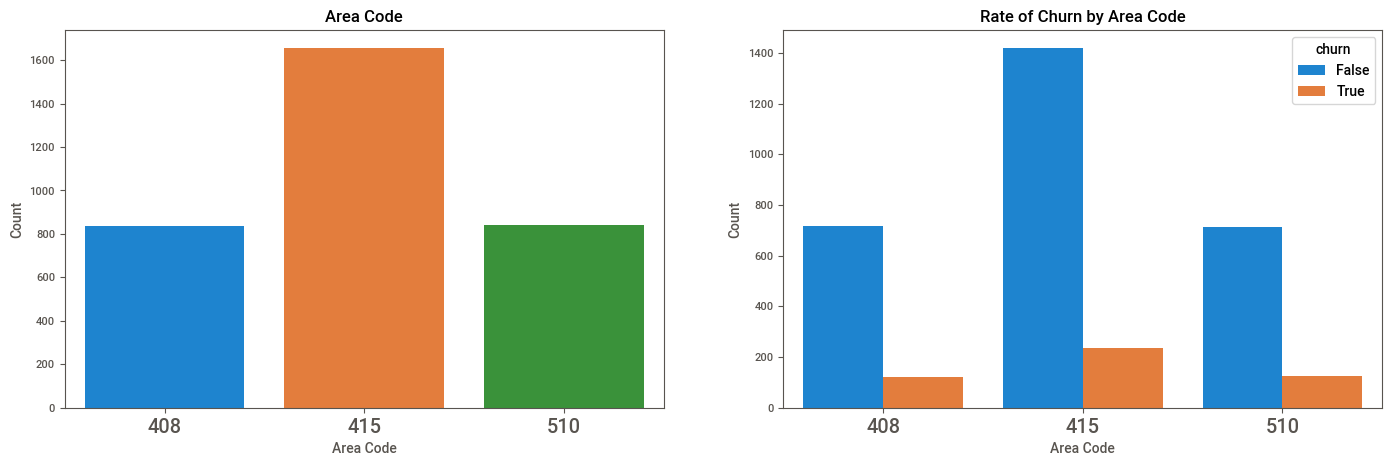

In [124]:
# Plot the distribution and then the distributions according to the class labels
f= plt.figure(figsize=(17,5))

ax=f.add_subplot(121)
ax=sns.countplot(x='area code', data=df_churn)
ax.set_xlabel('Area Code')
ax.set_ylabel('Count')
ax.set_title('Area Code')
ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

ax2=f.add_subplot(122)
sns.countplot(x = 'area code', hue = 'churn', data = df_churn)
ax2.set_xlabel('Area Code')
ax2.set_ylabel('Count')
ax2.set_title('Rate of Churn by Area Code')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

plt.show()

There is data for three area codes - 408, 415, and 510.  Area code 415 represents the largest value, but plotting by churn does not show much differentiation between the three.  I would anticipate area code will not be particularly relevant to prediction models. 

#### International Plan

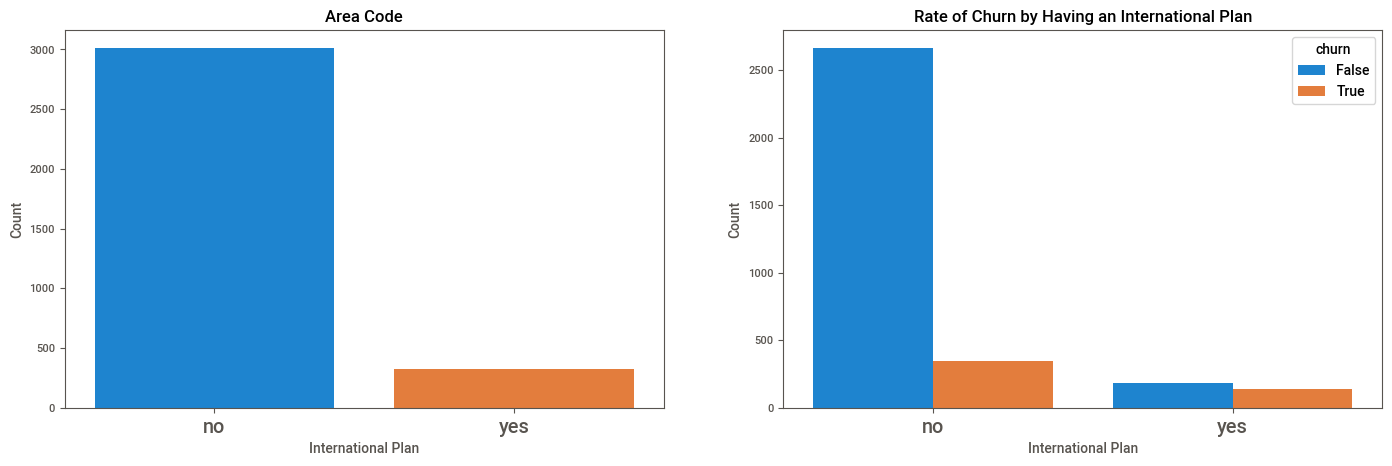

In [125]:
# Plot the distribution and then the distributions according to the class labels
f= plt.figure(figsize=(17,5))

ax=f.add_subplot(121)
ax=sns.countplot(x='international plan', data=df_churn)
ax.set_xlabel('International Plan')
ax.set_ylabel('Count')
ax.set_title('Area Code')
ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

ax2=f.add_subplot(122)
sns.countplot(x = 'international plan', hue='churn', data = df_churn)
ax2.set_xlabel('International Plan')
ax2.set_ylabel('Count')
ax2.set_title('Rate of Churn by Having an International Plan')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

plt.show()

Here there are only two values - yes and no.  Many more people do not have an internation plan than do, but those that do are almost split equally between churn and not churn.  

#### Voicemial Plan

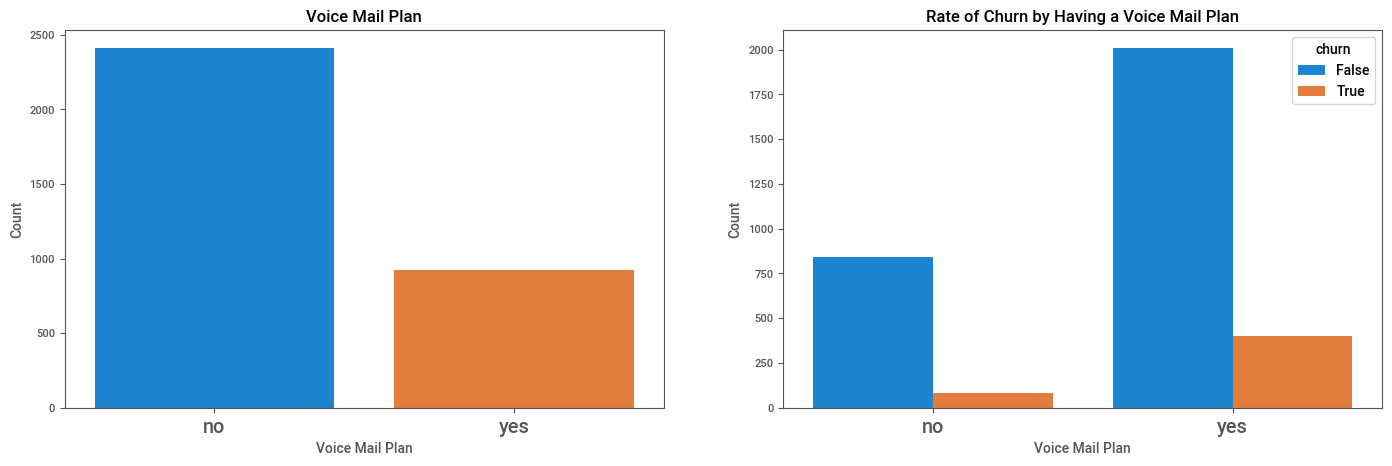

In [126]:
# Plot the distribution and then the distributions according to the class labels
f= plt.figure(figsize=(17,5))

ax=f.add_subplot(121)
ax=sns.countplot(x='voice mail plan', data=df_churn, order=['no', 'yes'])
ax.set_xlabel('Voice Mail Plan')
ax.set_ylabel('Count')
ax.set_title('Voice Mail Plan')
ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

ax2=f.add_subplot(122)
sns.countplot(x = 'voice mail plan', hue = 'churn', data = df_churn)
ax2.set_xlabel('Voice Mail Plan')
ax2.set_ylabel('Count')
ax2.set_title('Rate of Churn by Having a Voice Mail Plan')
ax2.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

plt.show()

Having a voicemail plan, on the other hand, does not seem very predictive of whether the customer will churn.  The distributions are reasonably close when looking at the plot on the right.

<b> Observations:</b>
Looking at the categorical features, state and international plan seem to be the most predictive of churn, while area code and voice mail plan do not seem very relevant. 

### Examining the Numeric Features

First I check the correlations between the the numeric features and the target, churn.

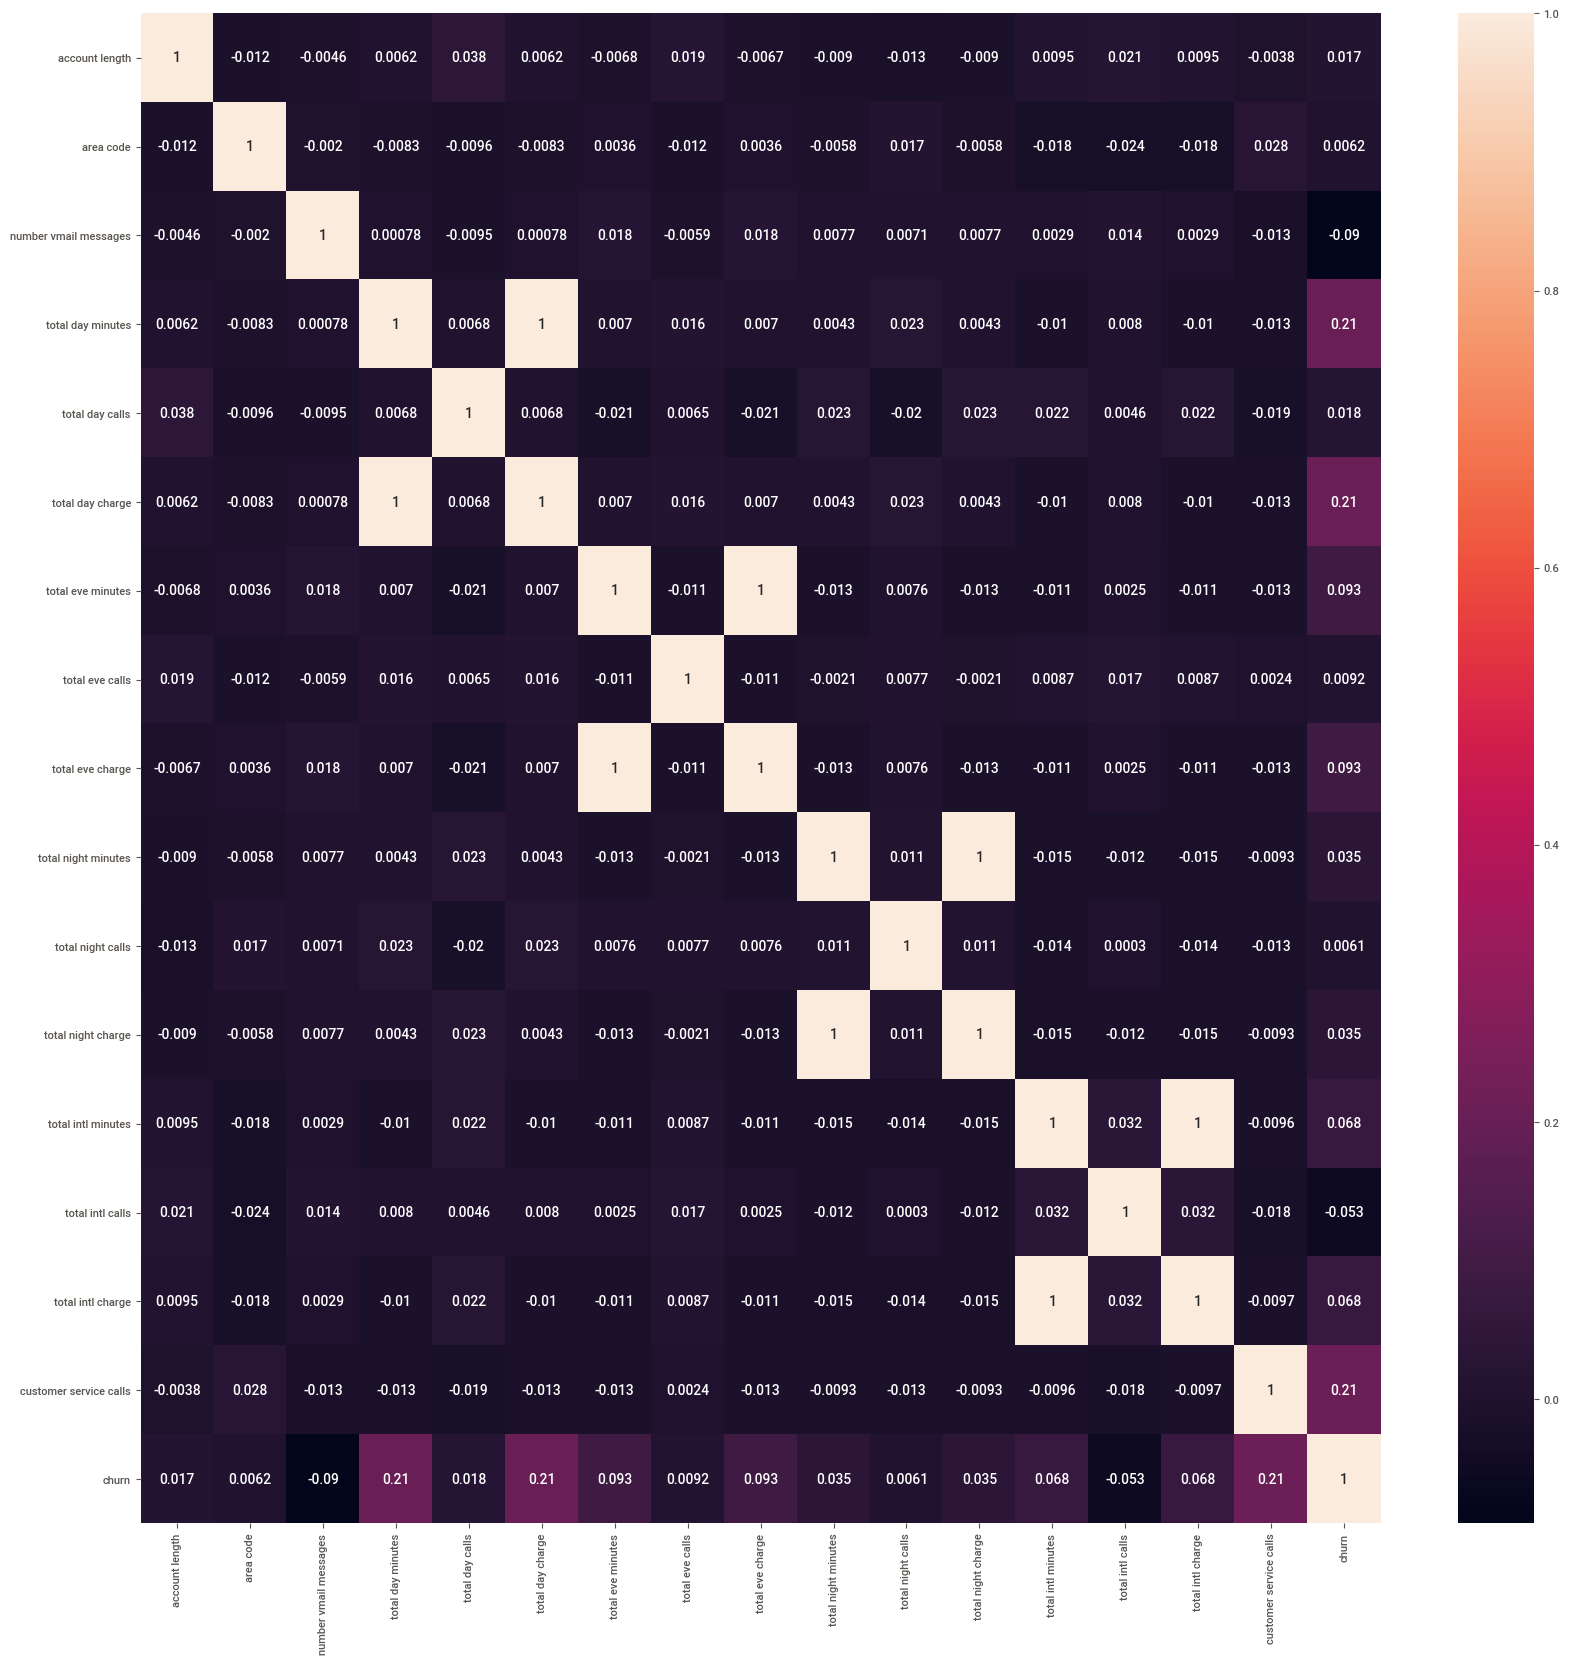

In [127]:
plt.figure(figsize=(20,20))
sns.heatmap(df_churn.corr(), annot=True)
plt.show()

The first thing of note here are the 1 values in the matrix - there is a perfect correlation between total day minutes and total day charges, as well as for the same pairs in other timeframes - evening, night, and internation.  My assumption would that there is a set price function for each time of day and so minutes and charges are perfectly related. 

I examine these pairs of features and then will come back to the correlation matrix.

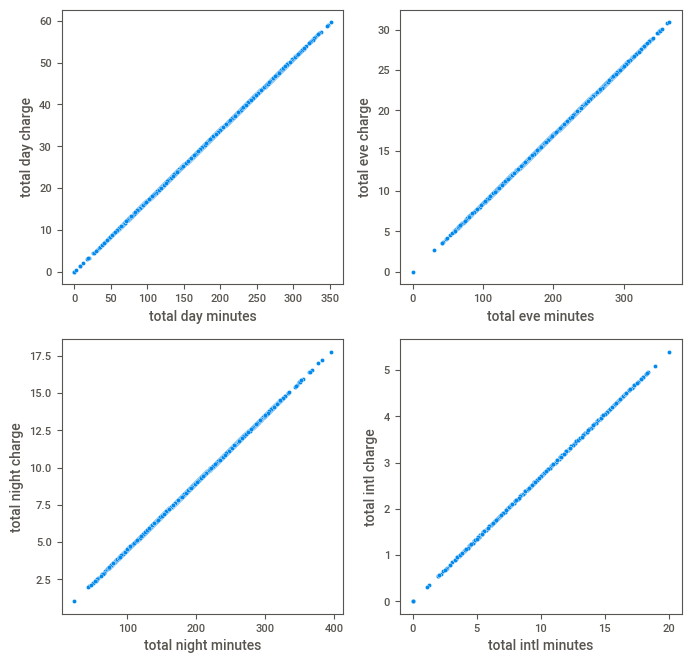

In [128]:
# Plotting minutes and charge against each other for day, eve, night, and internation
f= plt.figure(figsize=(8,8))

ax=f.add_subplot(221)
ax = sns.scatterplot(x='total day minutes', y='total day charge', data=df_churn)

ax2=f.add_subplot(222)
ax2 = sns.scatterplot(x='total eve minutes', y='total eve charge', data=df_churn)

ax3=f.add_subplot(223)
ax3 = sns.scatterplot(x='total night minutes', y='total night charge', data=df_churn)

ax4=f.add_subplot(224)
ax4 = sns.scatterplot(x='total intl minutes', y='total intl charge', data=df_churn)

plt.show()

We can see the perfect linear relationship between each pair of features.  Looking at the correlation matrix, for each timeframe the charge and the minutes features have the same correlation with churn.  So now I will drop one of each of these four pairs.

In [129]:
# Dropping total day minutes, total eve minutes, total night minutes, and total intl minutes
df_churn.drop(columns=['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes'], inplace=True)

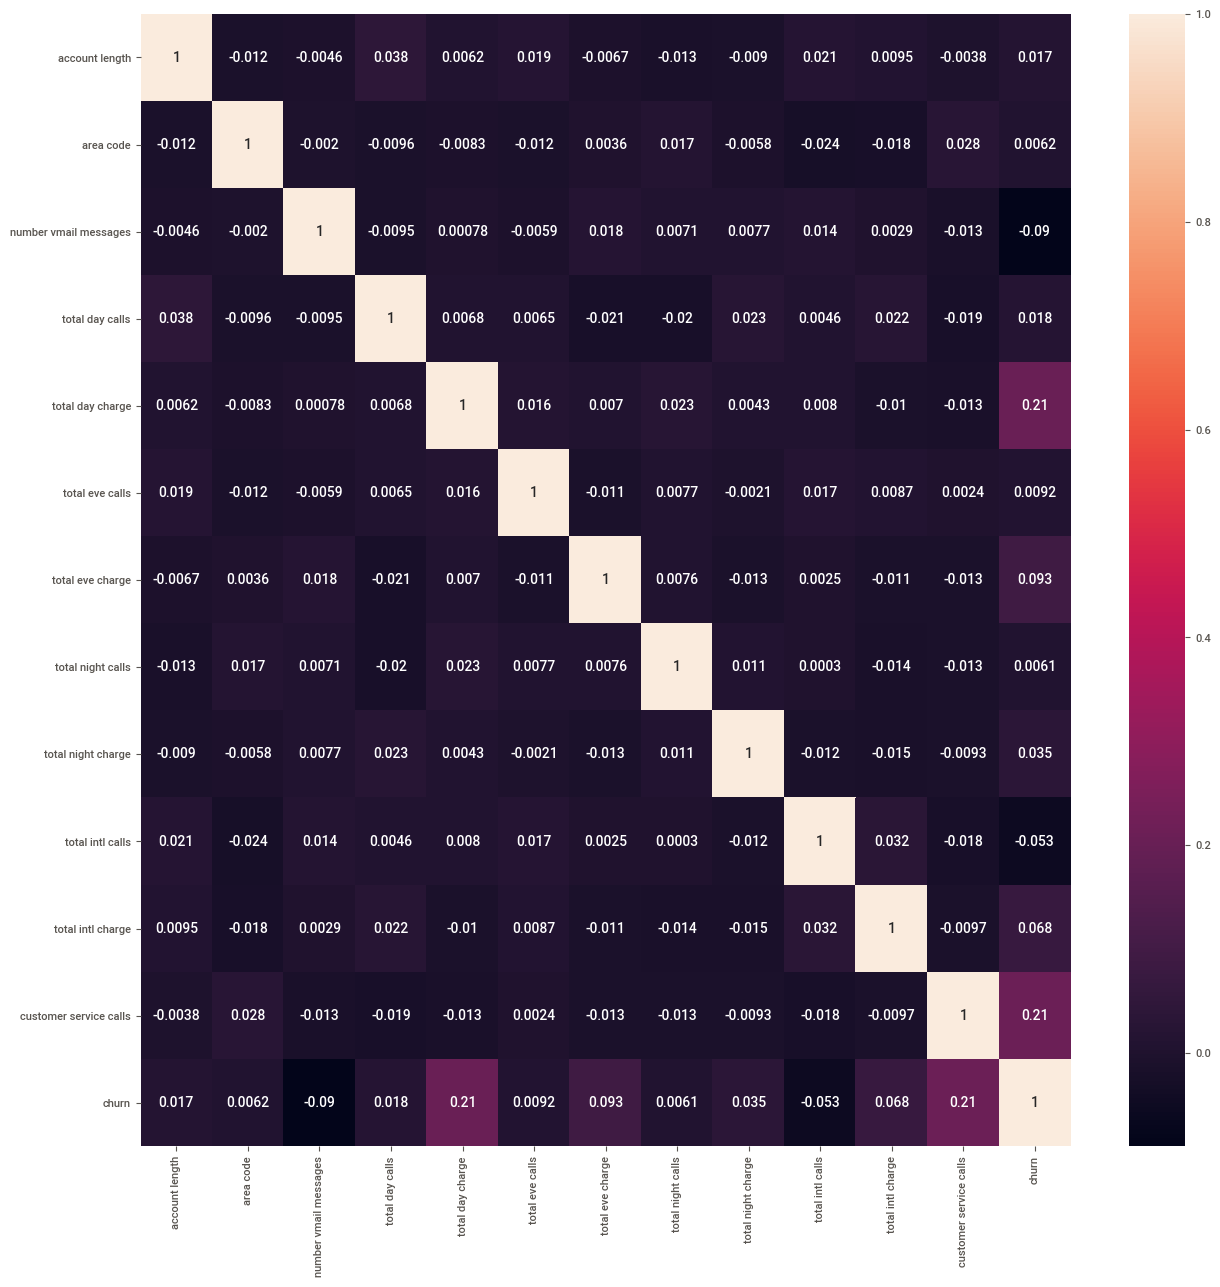

In [130]:
#Plot the new correlation matrix 
plt.figure(figsize=(15,15))
sns.heatmap(df_churn.corr(), annot=True)
plt.show()

Here we see that all of these features are independent and important.  Customer service calls and total day charges are the most correlated with churn.

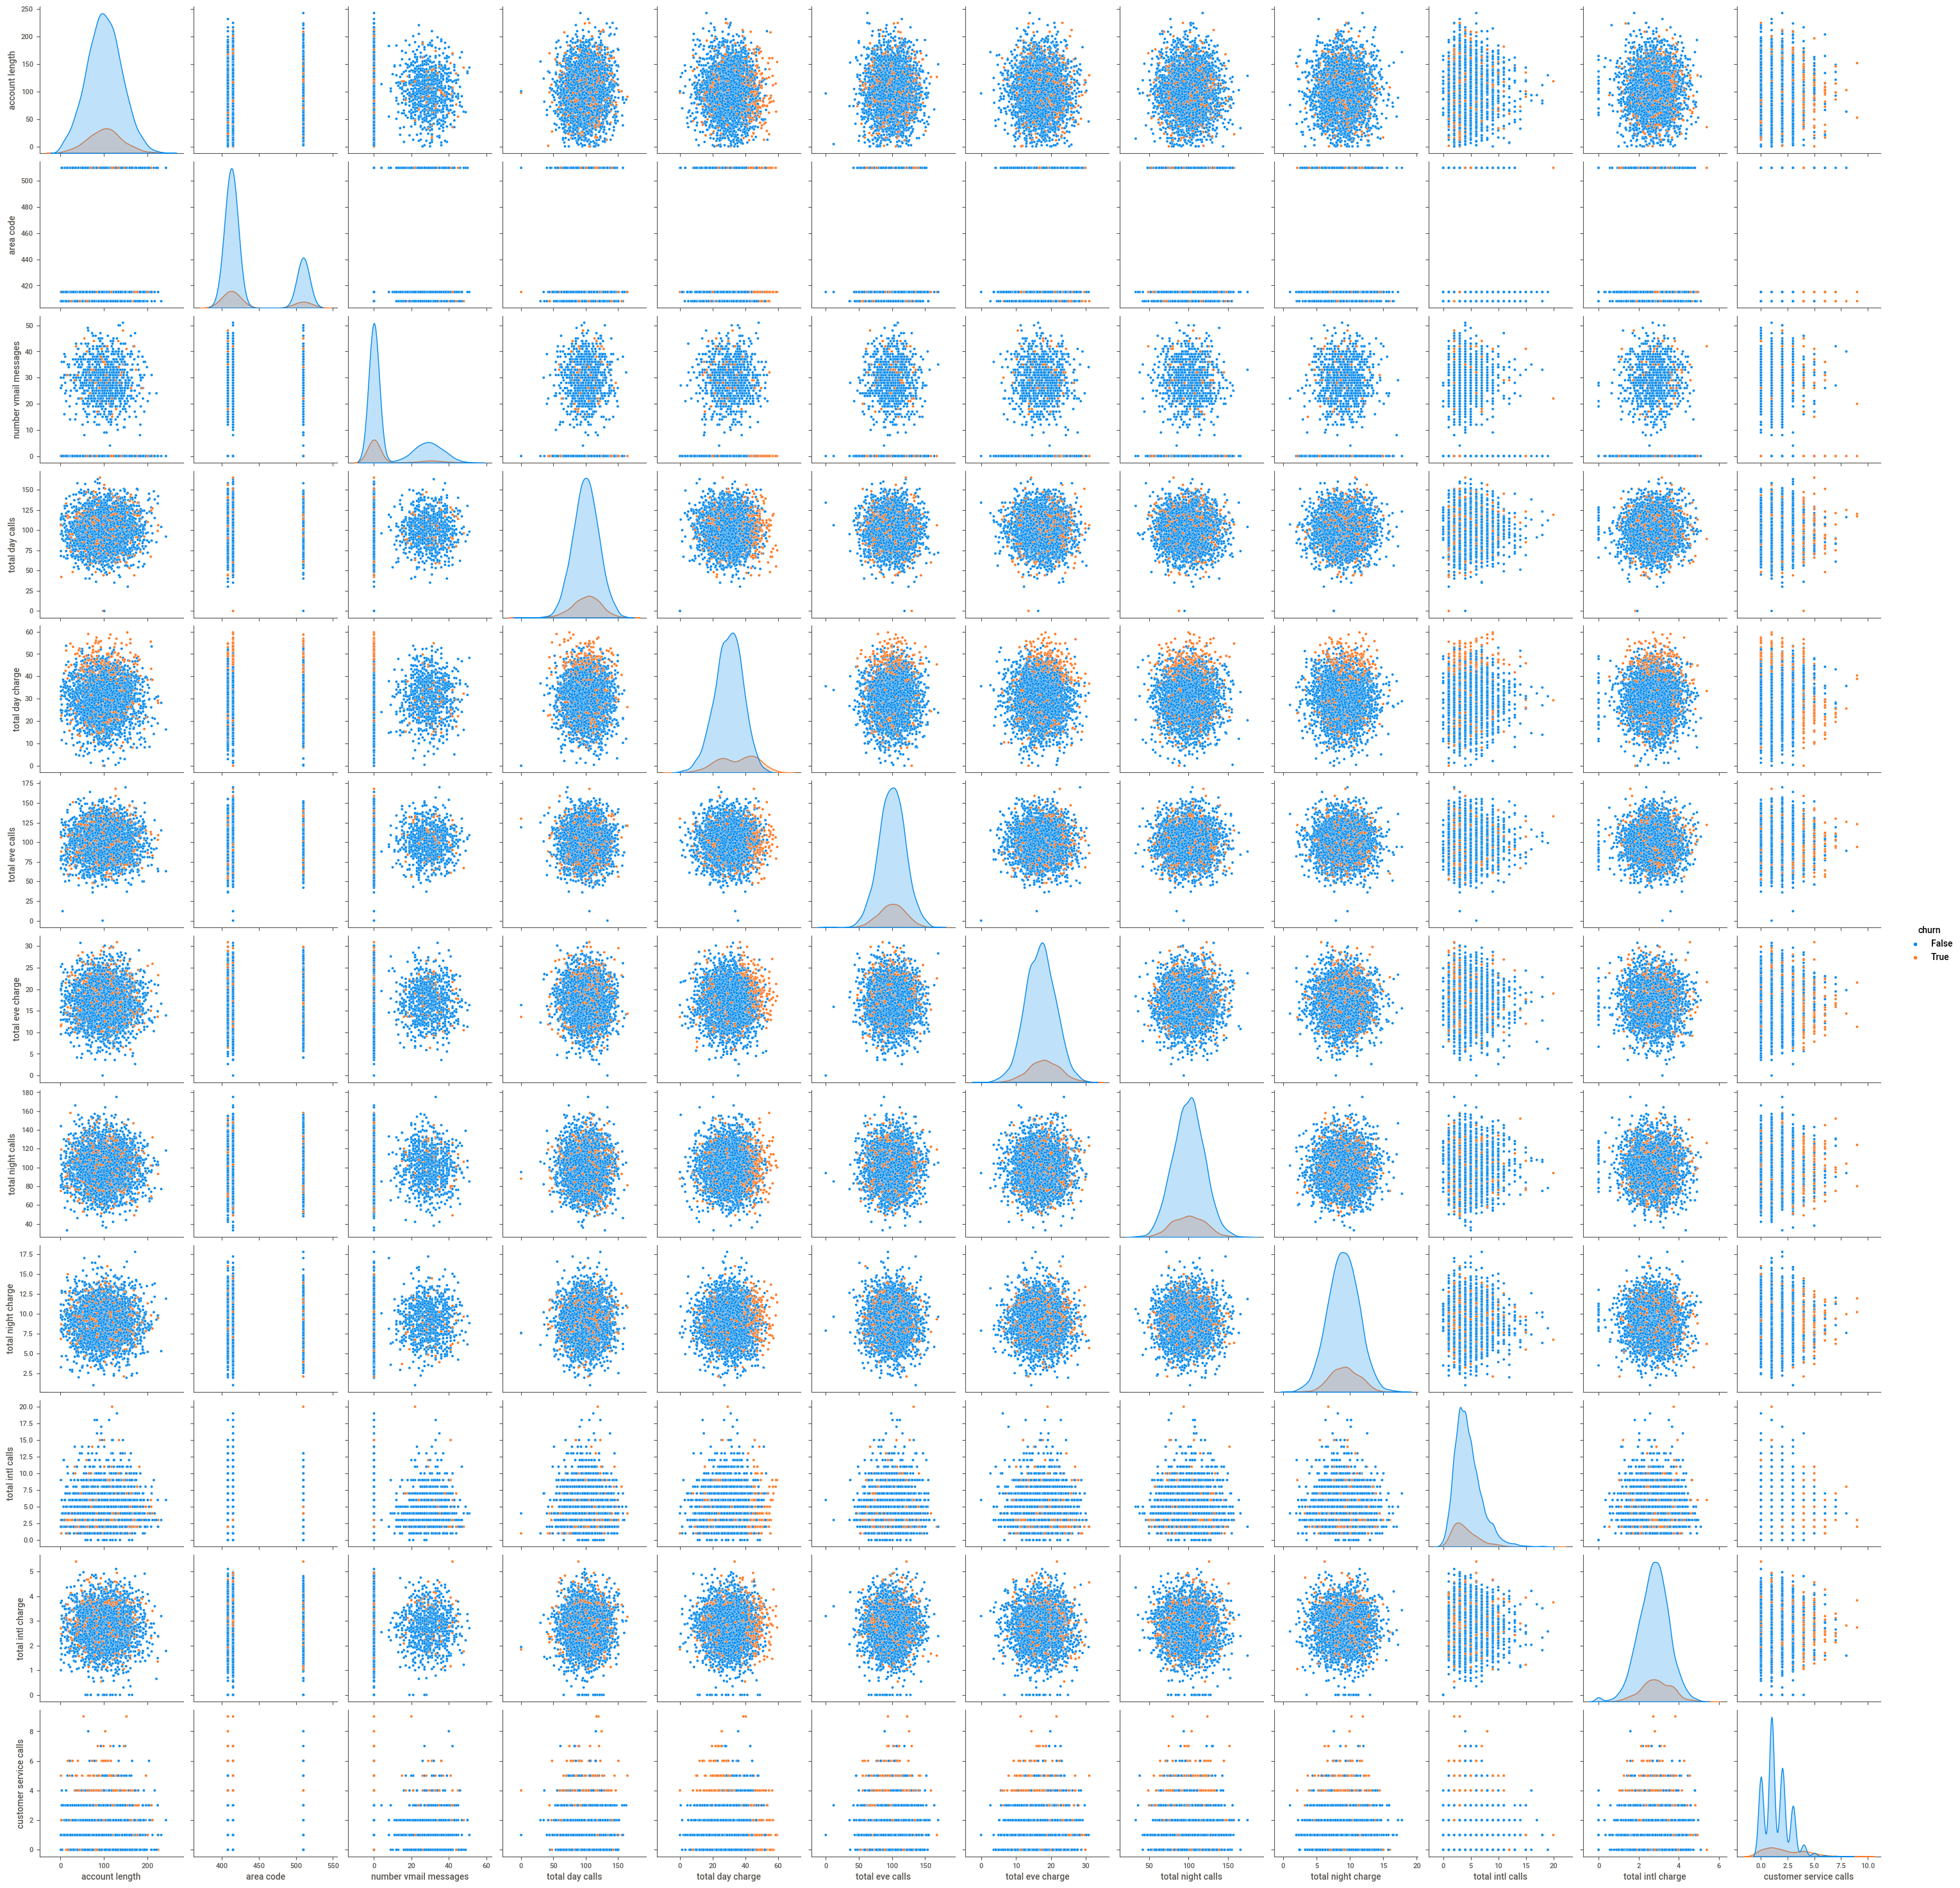

In [131]:
# Plot each of the features against the others using a pairplot 
sns.pairplot(df_churn, hue='churn')

We see that all almost features appear normally distributed and the distributions remain consistent between the two labels - churn and not churn.  There is not much separation between churn and not churn for the different features.  I will exmaine a few indiviudally now.

#### Account Length

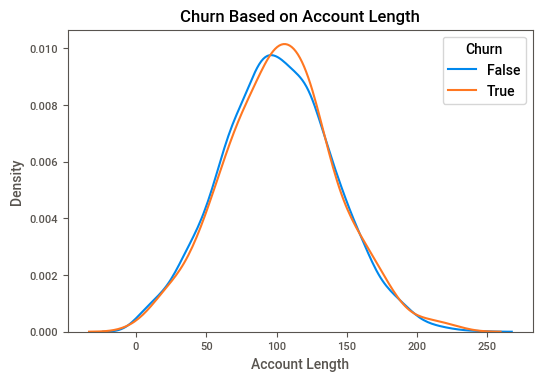

In [132]:
fig, ax = plt.subplots()
sns.kdeplot(df_churn[(df_churn.churn == 0)]['account length'],ax=ax, label = 'False')
sns.kdeplot(df_churn[(df_churn.churn == 1)]['account length'],ax=ax, label = 'True')
ax.set_title('Churn Based on Account Length')
ax.set_ylabel('Density')
ax.set_xlabel('Account Length')
plt.legend(title = 'Churn')

There is almost no distinguising churn based on account length.  I looking at the correlation matrix, account lenght hardly seems related to any of the other features.

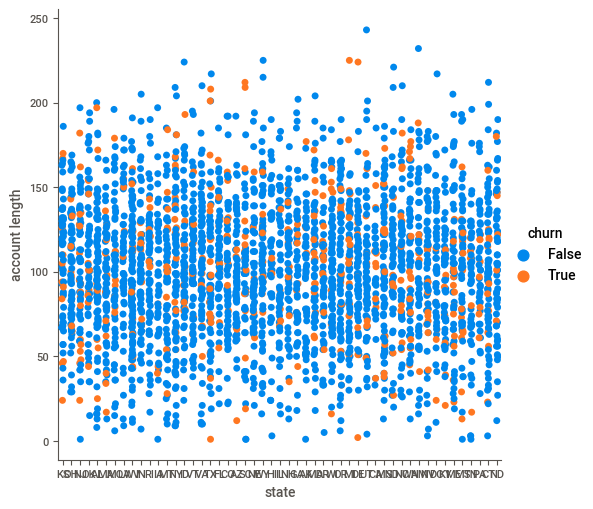

In [133]:
#### Account length vs State
sns.catplot(x="state", y="account length", data=df_churn, hue='churn')

Account length is consistent across the states and there is no noticeable split between the two targets.

#### Number of Voice Mail Messages

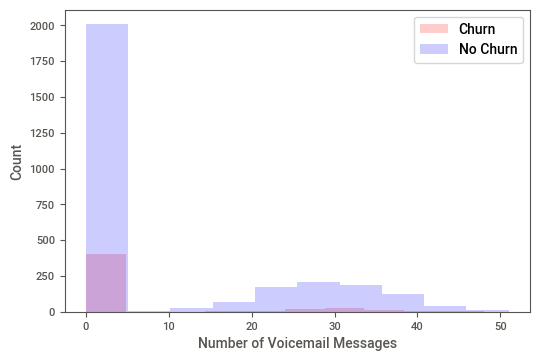

In [134]:
# Plotting a historgram of Voice Mail Messages by Churn
churn_vmail = df_churn[(df_churn.churn == 1)]["number vmail messages"]
no_churn_vmail = df_churn[(df_churn.churn == 0)]["number vmail messages"]
plt.hist(churn_vmail, alpha=0.2, color='r', label='Churn')
plt.hist(no_churn_vmail, alpha=0.2, color='b', label='No Churn')
plt.xlabel('Number of Voicemail Messages')
plt.ylabel('Count')
plt.legend()
plt.show()

With the number of voicemail messages, the distributions are the same for the two target classes. 

#### Total Day Charge

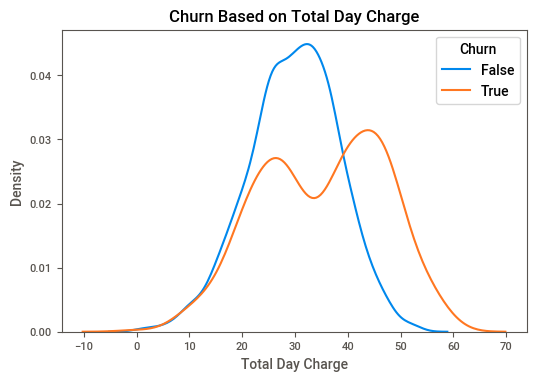

In [135]:
fig, ax = plt.subplots()
sns.kdeplot(df_churn[(df_churn.churn == 0)]["total day charge"],ax=ax, label = 'False')
sns.kdeplot(df_churn[(df_churn.churn == 1)]['total day charge'],ax=ax, label = 'True')
ax.set_title('Churn Based on Total Day Charge')
ax.set_ylabel('Density')
ax.set_xlabel('Total Day Charge')
plt.legend(title = 'Churn')

Total day charge at least shows some separation between the classes.  Those cusomters who have higher daily charges are more likely to churn - perhaps to migrate to another company that will offer lower prices.

#### Customer Service Calls

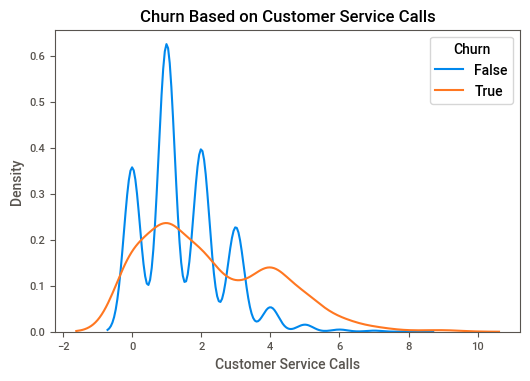

In [136]:
fig, ax = plt.subplots()
sns.kdeplot(df_churn[(df_churn.churn == 0)]['customer service calls'],ax=ax, label = 'False')
sns.kdeplot(df_churn[(df_churn.churn == 1)]['customer service calls'],ax=ax, label = 'True')
ax.set_title('Churn Based on Customer Service Calls')
ax.set_ylabel('Density')
ax.set_xlabel('Customer Service Calls')
plt.legend(title = 'Churn')

Customer service calls also shows a relation to churn.  Customers who call customer service more are more likely to churn.  These people may be having more issues or complains to call customer service about, and so they are more likely to take their business to a competitor.

### Feature Engineering

We have already dropped one of each pair of collinear features - total day minutes, total eve minutes, total night minutes, and total intl minutes.  We will also drop telephone number now becuase it is unique to each person and thus not predicative in any way.

In [138]:
df_churn.drop(columns=['phone number'], inplace=True)

In [139]:
df_churn.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn'],
      dtype='object')

#### Outlier Analysis

As was noted in the beginning there appear to be outliers but nothing that is too extreme.  To give an example, I will look at number vmail messages.

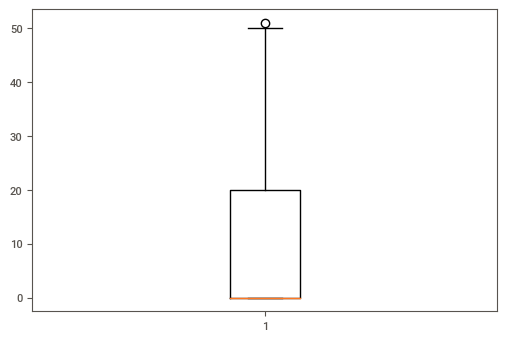

In [140]:
plt.boxplot(df_churn['number vmail messages'])
plt.show()

Here we see outliers that are just on the outside of the top arm of the box plot.  Next, I look at total day charges.

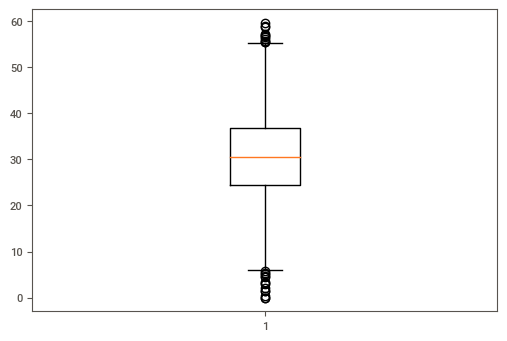

In [141]:
plt.boxplot(df_churn['total day charge'])
plt.show()

There appear to be quite a few.  Since the distribution is normal, we can define outliers as those that fall outside the range of one and a half times the IQR from the first and third quartiles. 

In [142]:
# Calculate the first and third quartiles and IQR
Q1 = df_churn['total day charge'].quantile(0.25)
Q3 = df_churn['total day charge'].quantile(0.75)
IQR = Q3 - Q1
# Find the lower and upper bound to define outliers
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [143]:
# Get the number of outliers on the low end
df_churn[(df_churn['total day charge'] < lower)].shape

(14, 16)

In [144]:
# Get the number of outliers on the high end
df_churn[(df_churn['total day charge'] > upper)].shape

(11, 16)

We see just 25 rows in total here could be considered outliers, out of the 3333 total rows.  And from the box plot that we could hardly consider these outliers to be extreme.

#### Scaling and Encoding the Data

In [145]:
df_churn

state  account length  area code international plan voice mail plan  \
0       KS             128        415                 no             yes   
1       OH             107        415                 no             yes   
2       NJ             137        415                 no              no   
3       OH              84        408                yes              no   
4       OK              75        415                yes              no   
...    ...             ...        ...                ...             ...   
3328    AZ             192        415                 no             yes   
3329    WV              68        415                 no              no   
3330    RI              28        510                 no              no   
3331    CT             184        510                yes              no   
3332    TN              74        415                 no             yes   

      number vmail messages  total day calls  total day charge  \
0                        25              110             45.07   
1                        26              123             27.47   
2                         0              114             41.38   
3                         0               71             50.90   
4                         0              113             28.34   
...                     ...              ...               ...   
3328                     36               77             26.55   
3329                      0               57             39.29   
3330                      0              109             30.74   
3331                      0              105             36.35   
3332                     25              113             39.85   

      total eve calls  total eve charge  total night calls  \
0                  99             16.78                 91   
1                 103             16.62                103   
2                 110             10.30                104   
3                  88              5.26                 89   
4                 122             12.61                121   
...               ...               ...                ...   
3328              126             18.32                 83   
3329               55             13.04                123   
3330               58             24.55                 91   
3331               84             13.57                137   
3332               82             22.60                 77   

      total night charge  total intl calls  total intl charge  \
0                  11.01                 3               2.70   
1                  11.45                 3               3.70   
2                   7.32                 5               3.29   
3                   8.86                 7               1.78   
4                   8.41                 3               2.73   
...                  ...               ...                ...   
3328               12.56                 6               2.67   
3329                8.61                 4               2.59   
3330                8.64                 6               3.81   
3331                6.26                10               1.35   
3332               10.86                 4               3.70   

      customer service calls  churn  
0                          1  False  
1                          1  False  
2                          0  False  
3                          2  False  
4                          3  False  
...                      ...    ...  
3328                       2  False  
3329                       3  False  
3330                       2  False  
3331                       2  False  
3332                       0  False  

[3333 rows x 16 columns]

First I will scale the numeric features using the standard scaler.  This will make their ranges consistent and ensure that features with larger scales are not given extra weight by the learning algorithms. 

In [146]:
df_churn.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn'],
      dtype='object')

In [147]:
# Get the numeric columns
nums_cols = ['account length', 'number vmail messages', 'total day calls', 'total day charge', 'total eve calls', 
             'total eve charge', 'total night calls', 'total night charge', 'total intl calls','total intl charge', 
             'customer service calls']

In [148]:
# Get the numeric features
nums_df = df_churn[nums_cols]
nums_df = nums_df.values

In [149]:
# Scale the numeric features
churn_scaler = StandardScaler()
nums_df_scaled = churn_scaler.fit_transform(nums_df)

In [150]:
# Replace these scaled features back into X
df_churn[nums_cols] = nums_df_scaled

In [151]:
# Print scaled data frame
df_churn 

state  account length  area code international plan voice mail plan  \
0       KS        0.676489        415                 no             yes   
1       OH        0.149065        415                 no             yes   
2       NJ        0.902529        415                 no              no   
3       OH       -0.428590        408                yes              no   
4       OK       -0.654629        415                yes              no   
...    ...             ...        ...                ...             ...   
3328    AZ        2.283878        415                 no             yes   
3329    WV       -0.830437        415                 no              no   
3330    RI       -1.835055        510                 no              no   
3331    CT        2.082955        510                yes              no   
3332    TN       -0.679745        415                 no             yes   

      number vmail messages  total day calls  total day charge  \
0                  1.234883         0.476643          1.567036   
1                  1.307948         1.124503         -0.334013   
2                 -0.591760         0.675985          1.168464   
3                 -0.591760        -1.466936          2.196759   
4                 -0.591760         0.626149         -0.240041   
...                     ...              ...               ...   
3328               2.038605        -1.167924         -0.433386   
3329              -0.591760        -2.164631          0.942714   
3330              -0.591760         0.426808          0.019193   
3331              -0.591760         0.227466          0.625153   
3332               1.234883         0.626149          1.003202   

      total eve calls  total eve charge  total night calls  \
0           -0.055940         -0.070427          -0.465494   
1            0.144867         -0.107549           0.147825   
2            0.496279         -1.573900           0.198935   
3           -0.608159         -2.743268          -0.567714   
4            1.098699         -1.037939           1.067803   
...               ...               ...                ...   
3328         1.299506          0.286880          -0.874374   
3329        -2.264816         -0.938172           1.170023   
3330        -2.114211          1.732349          -0.465494   
3331        -0.808966         -0.815203           1.885562   
3332        -0.909370          1.279915          -1.181033   

      total night charge  total intl calls  total intl charge  \
0               0.866029         -0.601195          -0.085690   
1               1.059390         -0.601195           1.241169   
2              -0.755571          0.211534           0.697156   
3              -0.078806          1.024263          -1.306401   
4              -0.276562         -0.601195          -0.045885   
...                  ...               ...                ...   
3328            1.547188          0.617898          -0.125496   
3329           -0.188670         -0.194831          -0.231645   
3330           -0.175486          0.617898           1.387123   
3331           -1.221396          2.243356          -1.876950   
3332            0.800110         -0.194831           1.241169   

      customer service calls  churn  
0                  -0.427932  False  
1                  -0.427932  False  
2                  -1.188218  False  
3                   0.332354  False  
4                   1.092641  False  
...                      ...    ...  
3328                0.332354  False  
3329                1.092641  False  
3330                0.332354  False  
3331                0.332354  False  
3332               -1.188218  False  

[3333 rows x 16 columns]

#### Encoding the Categorical Features

Since the state column has 51 values I will use get dummies (one hot encoding) for this.  This will create 51 new columns - one for each state - and give each row a value of 1 for its state, and 0 elsewhere.  I will do the same with the other categorical features - area code, international plan, and voice mail plan.

In [152]:
df_churn = pd.get_dummies(df_churn, columns = ['state', 'area code', 'international plan', 'voice mail plan'])

In [153]:
df_churn

account length  number vmail messages  total day calls  \
0           0.676489               1.234883         0.476643   
1           0.149065               1.307948         1.124503   
2           0.902529              -0.591760         0.675985   
3          -0.428590              -0.591760        -1.466936   
4          -0.654629              -0.591760         0.626149   
...              ...                    ...              ...   
3328        2.283878               2.038605        -1.167924   
3329       -0.830437              -0.591760        -2.164631   
3330       -1.835055              -0.591760         0.426808   
3331        2.082955              -0.591760         0.227466   
3332       -0.679745               1.234883         0.626149   

      total day charge  total eve calls  total eve charge  total night calls  \
0             1.567036        -0.055940         -0.070427          -0.465494   
1            -0.334013         0.144867         -0.107549           0.147825   
2             1.168464         0.496279         -1.573900           0.198935   
3             2.196759        -0.608159         -2.743268          -0.567714   
4            -0.240041         1.098699         -1.037939           1.067803   
...                ...              ...               ...                ...   
3328         -0.433386         1.299506          0.286880          -0.874374   
3329          0.942714        -2.264816         -0.938172           1.170023   
3330          0.019193        -2.114211          1.732349          -0.465494   
3331          0.625153        -0.808966         -0.815203           1.885562   
3332          1.003202        -0.909370          1.279915          -1.181033   

      total night charge  total intl calls  total intl charge  ...  state_WI  \
0               0.866029         -0.601195          -0.085690  ...         0   
1               1.059390         -0.601195           1.241169  ...         0   
2              -0.755571          0.211534           0.697156  ...         0   
3              -0.078806          1.024263          -1.306401  ...         0   
4              -0.276562         -0.601195          -0.045885  ...         0   
...                  ...               ...                ...  ...       ...   
3328            1.547188          0.617898          -0.125496  ...         0   
3329           -0.188670         -0.194831          -0.231645  ...         0   
3330           -0.175486          0.617898           1.387123  ...         0   
3331           -1.221396          2.243356          -1.876950  ...         0   
3332            0.800110         -0.194831           1.241169  ...         0   

      state_WV  state_WY  area code_408  area code_415  area code_510  \
0            0         0              0              1              0   
1            0         0              0              1              0   
2            0         0              0              1              0   
3            0         0              1              0              0   
4            0         0              0              1              0   
...        ...       ...            ...            ...            ...   
3328         0         0              0              1              0   
3329         1         0              0              1              0   
3330         0         0              0              0              1   
3331         0         0              0              0              1   
3332         0         0              0              1              0   

      international plan_no  international plan_yes  voice mail plan_no  \
0                         1                       0                   0   
1                         1                       0                   0   
2                         1                       0                   1   
3                         0                       1                   1   
4                         0                       1            

In [154]:
# Set the target as y and the rest as X
y = df_churn['churn']
X = df_churn.drop(columns=['churn'])

In [155]:
X.shape

(3333, 69)

In [156]:
y.shape

(3333,)

### Support Vector Machines

SVM is a supervised machine learning classification model.  I will create different models here - tuning parameters and employing Stratified k-Fold cross-validation as a attempt to rectify the imbalance in the class distribution.

In [157]:
# First, split the data into training, validation, and testing sets
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.4, random_state=0)
(X_validation, X_test, y_validation, y_test) = train_test_split(X_vt, y_vt, test_size=0.5, random_state=0)

In [158]:
# Create an SVM Classifier and fit it on the training data
clf = SVC()
clf.fit(X_train,y_train)

SVC()

In [159]:
# Make predictions on the training and validation data sets
yhat_train_p1 = clf.predict(X_train)
yhat_validation_p1 = clf.predict(X_validation)

In [160]:
# Print these accuracies
print(balanced_accuracy_score(yhat_train_p1, y_train), balanced_accuracy_score(yhat_validation_p1, y_validation))

0.9493439419318817 0.9047640625944051


The classifier is performing very well on training and validation data.

Before predicting the labels for the testing data we can try out different hyperparameters to see if the accuracy is made better. 

There are two parameters we can tune - C and gamma.  C can be used to change the sensitivity of the algorithm.  A higher C value tries to classifiy all training examples correctly and so it can overfit and fail to generalize.  The default value is 1.  A lower C does the opposite, simplying the decision surface so that the model is better able to generalize. 

#### Test with a higher C

In [161]:
clf2 = SVC(C=10)
clf2.fit(X_train,y_train)

SVC(C=10)

In [162]:
yhat_train_p2 = clf2.predict(X_train)
yhat_validation_p2 = clf2.predict(X_validation)

In [163]:
print(balanced_accuracy_score(yhat_train_p2, y_train), balanced_accuracy_score(yhat_validation_p2, y_validation))

0.9970725995316159 0.8197337640637183


We see the effect here - almost 100% accuracy on the training data but the accuracy on the validation data has decreased significantly.

#### Test with a Lower C

In [164]:
clf3 = SVC(C=0.5)
clf3.fit(X_train,y_train)

SVC(C=0.5)

In [165]:
yhat_train_p3 = clf3.predict(X_train)
yhat_validation_p3 = clf3.predict(X_validation)

In [166]:
print(balanced_accuracy_score(yhat_train_p3, y_train), balanced_accuracy_score(yhat_validation_p3, y_validation))

0.9353741983508933 0.9373040752351097


We see here a slight decrease in the training data accuracy and a slight increase in the validation data accuracy using a C of 0.5.  

The defaul gamma is 1 divided by the number of features - where here we 69.  This is a value of about 0.015.  As you increase the value of gamma you get more accuracy but more bias in your predictions.  

In [167]:
clf4 = SVC(C=0.5, gamma=0.1)
clf4.fit(X_train,y_train)

SVC(C=0.5, gamma=0.1)

In [168]:
yhat_train_p4 = clf4.predict(X_train)
yhat_validation_p4 = clf4.predict(X_validation)

In [169]:
print(balanced_accuracy_score(yhat_train_p4, y_train), balanced_accuracy_score(yhat_validation_p4, y_validation))

0.947403317367394 0.9359375


Raising the value of gamma gives a slight boost to the training data and a slight reduction to the validation data.

#### Trying with Different Kernels

In [170]:
clf5 = SVC(kernel='poly', degree=3)
clf5.fit(X_train,y_train)

SVC(kernel='poly')

In [171]:
yhat_train_p5 = clf5.predict(X_train)
yhat_validation_p5 = clf1.predict(X_validation)

In [172]:
print(balanced_accuracy_score(yhat_train_p5, y_train), balanced_accuracy_score(yhat_validation_p5, y_validation))

0.9724596403796812 0.8806442335346563


The poly kernel overfits the training data and does not generalize to the validation set as well as previous models.

In [176]:
clf6 = SVC(kernel='sigmoid')
clf6.fit(X_train,y_train)

SVC(kernel='sigmoid')

In [177]:
yhat_train_p6 = clf6.predict(X_train)
yhat_validation_p6 = clf1.predict(X_validation)

In [178]:
print(balanced_accuracy_score(yhat_train_p6, y_train), balanced_accuracy_score(yhat_validation_p6, y_validation))

0.5131834892270464 0.8806442335346563


The sigmoid kernel performs extremely poorly on the training data.

#### Model Selection

The best accuracy came with model 4 - a C value of 0.5 and a gamma value of 0.1.  It is this model that the test accuracy will be computed for now.

In [179]:
yhat_test = clf4.predict(X_test)
balanced_accuracy_score(yhat_test, y_test)

0.9312459389213774

We achieve 0.931 accuracy on the unseen testing data.  We can plot a confusion matrix for this model now.

In [180]:
confusion_matrix(y_test, yhat_test)

array([[593,   1],
       [ 55,  18]], dtype=int64)

We see that the mistaken predictions total 56, but all but one of these are false negatives. We can take a look next at the classification report. 

In [181]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

       False       0.92      1.00      0.95       594
        True       0.95      0.25      0.39        73

    accuracy                           0.92       667
   macro avg       0.93      0.62      0.67       667
weighted avg       0.92      0.92      0.89       667



We know that false makes up about 85% of our data, and the model is doing very well on this.  For the true predictions, however, it is not doing very well - an F1 score of 0.39.  We see that the precious is much higher than the recall for this class.  What that means is that it on the data it is classifying as true, it is doing very well (0.95), but it is not making enough true classification.  It is only identify 0.25 of all the true data in the dataset.

We noted the imbalance in the distribution of the targets, and so we will now employ Stratified k-Fold cross-validation to see if we can improve on this.

The idea behind cross-validation is to split the data k-times.  Here we will use a value of 10.  The model is trained on 9 of these subsets and tested on the remaining one.  This process is continued so that each subset becomes the test set once.  

Stratified k-Fold cross-validation makes the folds in a way that preserves the class distributions, creating subsets that contain as close to the same number of samples for each class as possible.

### Cross-Validation

In [182]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [183]:
#Split the data
X_train_cross, X_test_cross, y_train_cross, y_test_cross = train_test_split(X, y, stratify = df_churn.churn, random_state=0)

In [184]:
# Employ stratified k-fold cross validation with a k-value of 10
strat_k_fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# The score is the average of the scores on each of the testing sets.  
# Here we use SVC with the parameters of our previously best model.
score = cross_val_score(SVC(C=0.5, gamma=0.1), X, y, cv=strat_k_fold, scoring='accuracy').mean()
print(score)

0.8919898940857026


In this case our accuracy has been reduced.  

### Conclusion

Our best SVM classifier achieved a balanced accuracy score of 0.93125.  Our model is very good at predicting churn given all of the customer data we have at our disposal.  

This analysis did several thing - it found redundant features, scaled the numeric features, and encoded the categorical features.  In the end we tested several different SVM models with different parameters.  We tested the result of stratified k-fold cross validation.  In the end we found a model that achieved great accuracy, but upon examination it is clear that the model is struggling on the smaller class (churn).  

The result is that this model with this data is extremely accurate at predicting which customers will not churn, but it is not as accurate predicting those who will.